In [1]:
import pandas as pd
import pylab as plt
import numpy as np

df=pd.read_csv("Harzgerode_train.csv", infer_datetime_format=True, index_col="date")
df["date"]=pd.to_datetime(df.index)
df.set_index(df["date"], inplace=True)
df.drop("date", axis=1, inplace=True)

df["timestep"]=(df.index-df.index[0]).days.to_numpy()

(7305.0, 10957.0)

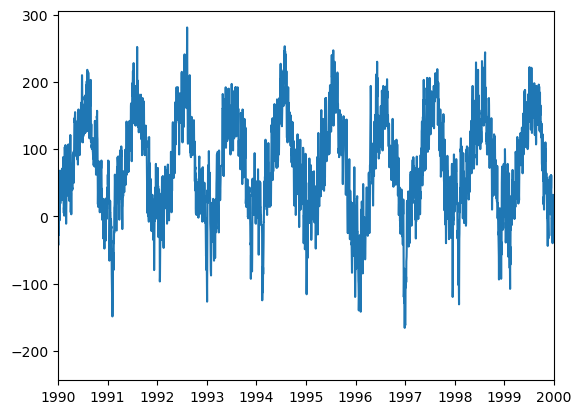

In [2]:
plt.plot(df.index, df["temp"])
plt.xlim(pd.Timestamp('1990-01-01'), pd.Timestamp('2000-01-01'))

## Estimating Trend using Polynominal Features

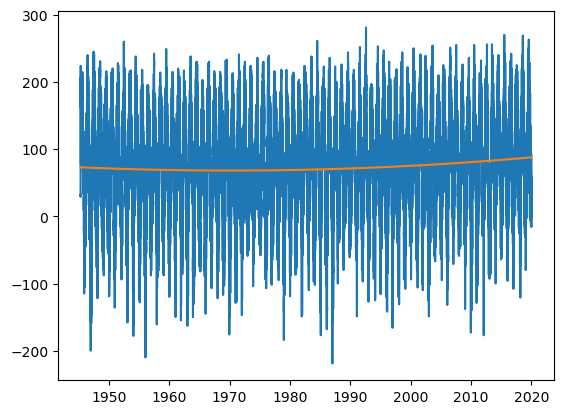

In [3]:
from sklearn.linear_model import LinearRegression
m_poly=LinearRegression()

df["t²"]=df["timestep"]**2

m_poly.fit(df[["timestep", "t²"]], df["temp"])

df["trend"]=m_poly.predict(df[["timestep", "t²"]])
plt.plot(df.index,df["temp"])
plt.plot(df.index,df["trend"]);

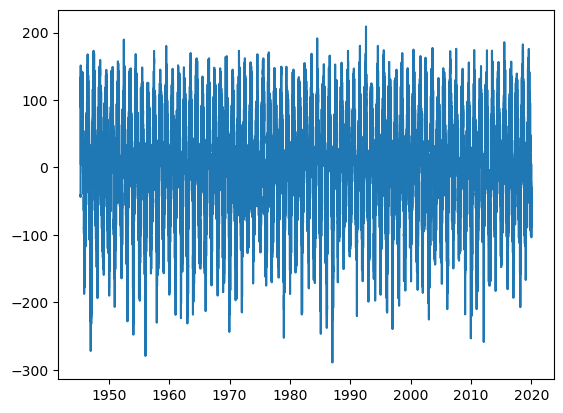

In [4]:
df["detrend"] = df["temp"]-df["trend"]
plt.plot(df.index,df["detrend"])

### Perform Frequency Analysis to get Seasonality

In [5]:
def frequency_analysis(df,feature="temp", zeropad=10000000):
    import numpy as np
    X=df.index
    DAYS=(X-X[0]).days.to_numpy()
    Y=df[feature]
    Yzp=np.r_[Y.to_numpy(), np.zeros(zeropad)]
    # Fourier Transformation
    from numpy import fft
    freq=fft.fftfreq(len(Yzp), 1)
    spec=fft.fft(Yzp)
    gz= ((np.divide(1,freq, where=np.abs(freq)>0)<365*20)  * (freq>0))
    return freq[gz],spec[gz]

In [45]:
freq_dt,spec_dt=frequency_analysis(df[["detrend"]], feature="detrend")

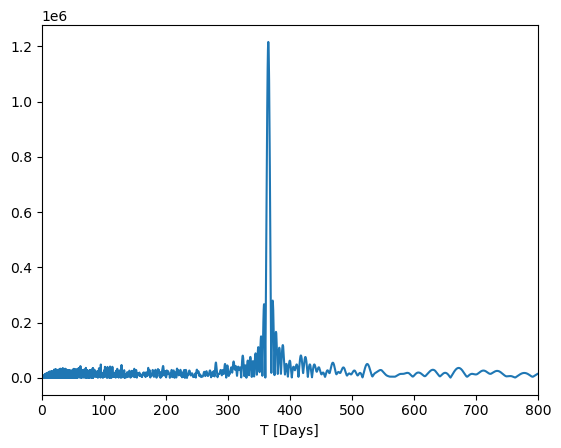

In [53]:
plt.plot(1/freq_dt, np.abs(spec_dt))
plt.xlim(0,800)
plt.xlabel("T [Days]");

#### The spectrum has a strong peak at T=365.25 --> yearly seasonality 

#### Now: check the phase at this period to get the phaseshift of the cos function

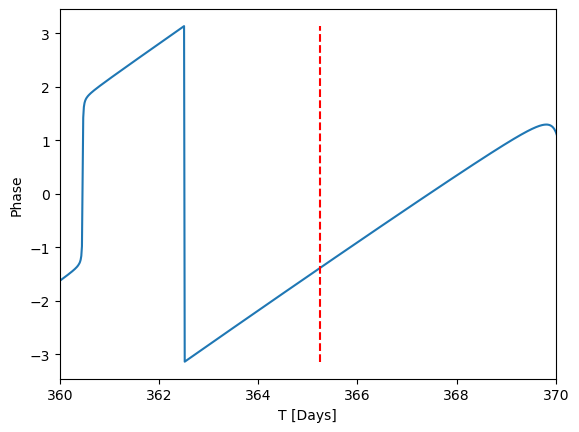

In [61]:
plt.plot(1/freq_dt, np.angle(spec_dt))
plt.xlim(360,370)
plt.ylabel("Phase")
plt.plot([mainT,mainT], [-np.pi,np.pi], "r--")
plt.xlabel("T [Days]");

In [117]:
aspec=np.abs(spec)
phase_spec=np.angle(spec)
mainT=round(1/freq[aspec==aspec.max()][0],2)
phase=round(phase_spec[aspec==aspec.max()][0],7)
print("Main Period is ", mainT ,"days, which is close to 365.25 days")
print("The phase of the main Period is ", phase, phase*180/np.pi )

Main Period is  365.25 days, which is close to 365.25 days
The phase of the main Period is  -1.3801505 -79.07679874287034


#### => Main Period is  365.25 days with a phase of  -1.38  or   -79.1°

### Define Cos Feature with this Period and phase:

In [118]:
freq_cos=1/mainT
df["cosi"]=df["timestep"].apply(lambda t: np.cos(2*np.pi*freq_cos * t + phase))

In [9]:
m_season=LinearRegression()
m_season.fit(df[["cosi"]], df["detrend"])
df["season"]=m_season.predict(df[["cosi"]])


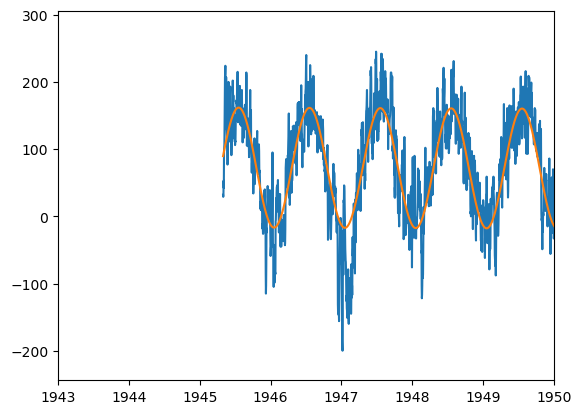

In [10]:
#Baseline model
plt.plot(df.index,df["temp"])
plt.plot(df.index, df["season"]+df["trend"])

    
    
plt.xlim(pd.Timestamp('1943-01-01'), pd.Timestamp('1950-01-01'));

(3652.0, 18993.0)

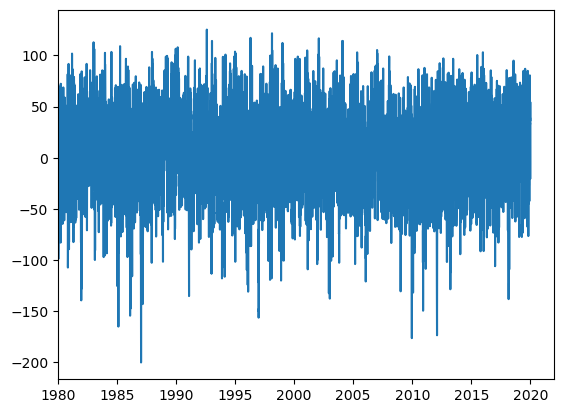

In [11]:
df["remainder"]=df["detrend"]-df["season"]

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(df.index, df["remainder"])
ax1.set_xlim(pd.Timestamp('1980-01-01'), pd.Timestamp('2022-01-01'))

### Comparisson of Spectrum before and after removing seasonality

In [37]:
frq_rem, spec_rem=frequency_analysis(df[["remainder"]], "remainder")

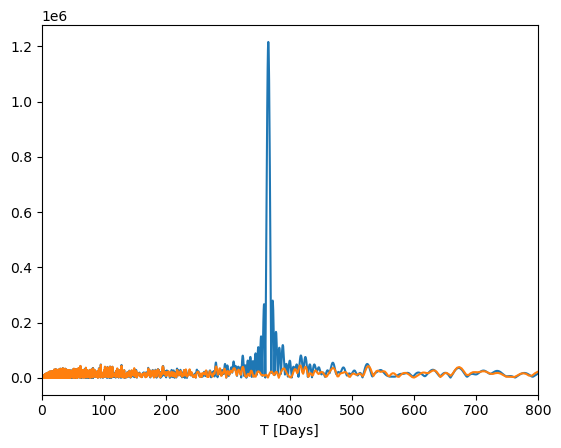

In [51]:

plt.plot(1/freq_dt, np.abs(spec_dt))
plt.plot(1/frq_rem, np.abs(spec_rem))
plt.xlim(0,800)
plt.xlabel("T [Days]");

### Modelling the remainder

In [214]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima
import pmdarima as pm

In [13]:
def adfuller_test(series):
    result=adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating data is non-stationary")

        
adfuller_test(df['remainder'])

ADF Test Statistic : -46.13946696963314
p-value : 0.0
#Lags Used : 4
Number of Observations Used : 27268
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [27]:
auto_arima_model = auto_arima(df['remainder'], 
                              start_p=0, start_q=0, 
                              max_p=10, max_q=10, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=276469.804, Time=0.96 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=248463.793, Time=2.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=257577.785, Time=7.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=276467.804, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=247855.793, Time=2.64 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=247654.423, Time=3.75 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=247652.542, Time=4.58 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=247643.759, Time=5.19 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=247645.152, Time=6.67 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=247642.259, Time=84.00 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=247657.938, Time=10.79 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=247647.412, Time=13.21 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=247637.062, Time=81.59 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=247646.862, Time=34.13 sec


In [53]:
auto_arima_model

ARIMA(order=(5, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

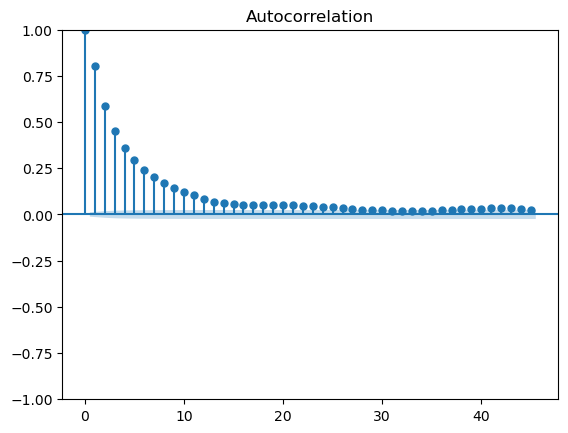

In [82]:
plot_acf(df["remainder"]);

/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


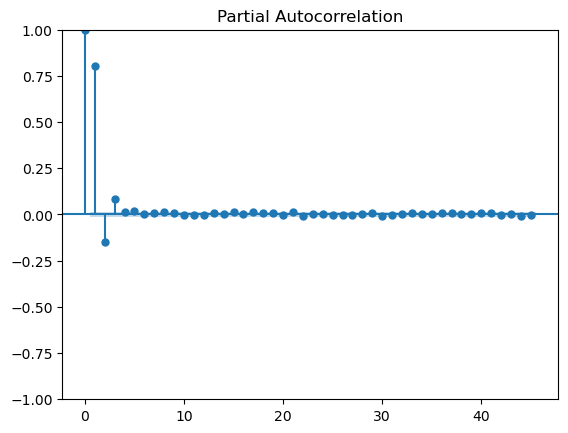

In [83]:
plot_pacf(df["remainder"]);

In [110]:
df_test=pd.read_csv("Harzgerode_test.csv", infer_datetime_format=True, index_col="date")
df_test["date"]=pd.to_datetime(df_test.index)
df_test.set_index(df_test["date"], inplace=True)
df_test.drop("date", axis=1, inplace=True)

df_test["timestep"]=(df_test.index-df.index[0]).days.to_numpy()

In [111]:
df_test["t²"]=df_test["timestep"]**2
df_test["cosi"]=df_test["timestep"].apply(lambda t: np.cos(2*np.pi*freq_cos*t + phase))

In [120]:
df_test.head()

,temp,timestep,t²,cosi
date,,,,
2020-01-01,-2.0,27273,743816529,-0.950564
2020-01-02,20.0,27274,743871076,-0.955765
2020-01-03,37.0,27275,743925625,-0.960683
2020-01-04,23.0,27276,743980176,-0.965317
2020-01-05,8.0,27277,744034729,-0.969665


In [130]:
df_test["trend"]    =   m_poly.predict(df_test[["timestep","t²"]])
df_test["season"]   = m_season.predict(df_test[["cosi"]])

df_test["remainder"]= df_test["temp"]-df_test["trend"]-df_test["season"]
df_test["detrend"]  = df_test["temp"]-df_test["trend"]

<AxesSubplot:xlabel='date'>

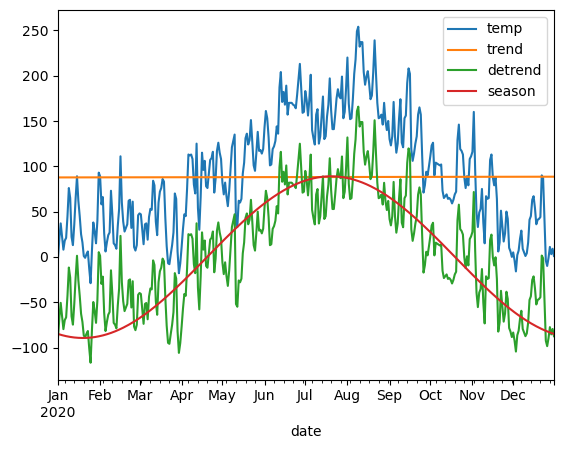

In [416]:
df_test[["temp",  "trend", "detrend", "season"]].plot()

(17532.0, 18628.0)

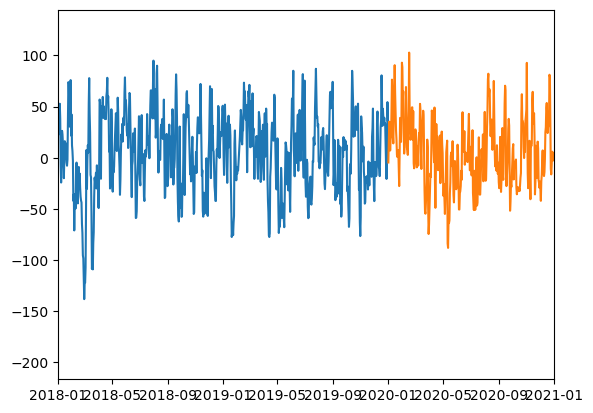

In [256]:
plt.plot(df.index,df[['remainder']])
plt.plot(df_test.index,df_test[['remainder']])
plt.xlim(pd.Timestamp("2018-01-01"), pd.Timestamp("2021-01-01"))

### Train ARMA for remainder

In [184]:
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm

model_rem =  pm.ARIMA(order=(5,0,2))

model_rem.fit(df[['remainder']].loc["2000":])

### in sample prediction (for train data):

(17532.0, 17897.0)

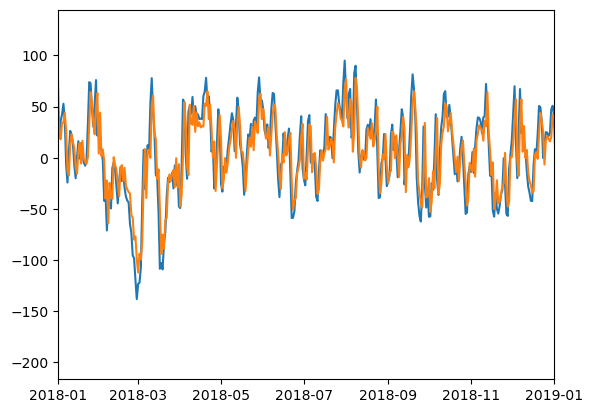

In [372]:
plt.plot(df.index,df["remainder"])
plt.plot(df.loc["2000":].index,model_rem.predict_in_sample())
plt.xlim(pd.Timestamp("2018-01-01"),pd.Timestamp("2019-01-01"))

## Now predict into the future

In [373]:
# 1D,2D forcast:

# the forcast is done into the future and afterwards the model gets updated with
# the actual data (from the test dataset) of the current day.

firstday=pd.Timestamp("2020-01-01")

forcasts1D=[]
forcasts2D=[0,]
dates=[]
for i in range(365):
    today=firstday + i * pd.Timedelta("1D")
    print(today)

    forcast_today=model_rem.predict(2)
    forcasts1D.append(forcast_today[0])
    forcasts2D.append(forcast_today[1])
    dates.append(today)
    
    updatevalue=df_test["remainder"][df_test.index==today]
    model_rem.update(updatevalue)
    
df_forcast=pd.DataFrame(forcasts1D, index=dates, columns=["forcast"])
 

2020-01-01 00:00:00
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-04 00:00:00
2020-01-05 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-11 00:00:00
2020-01-12 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-18 00:00:00
2020-01-19 00:00:00
2020-01-20 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-25 00:00:00
2020-01-26 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-07 00:00:00
2020-02-08 00:00:00
2020-02-09 00:00:00
2020-02-10 00:00:00
2020-02-11 00:00:00
2020-02-12 00:00:00
2020-02-13 00:00:00
2020-02-14 00:00:00
2020-02-15 00:00:00
2020-02-16 00:00:00
2020-02-17 00:00:00
2020-02-18 00:00:00
2020-02-19 00:00:00


In [374]:
i=365
today=firstday + i * pd.Timedelta("1D")
print(today)

forcast_today=model_rem.predict(2)
forcasts1D.append(forcast_today[0])
forcasts2D.append(forcast_today[1])
dates.append(today)

2020-12-31 00:00:00


In [376]:
df_forcast=pd.DataFrame(forcasts1D, index=dates, columns=["forcast"])
df_forcast["forcast_2D"]=forcasts2D[:-1]   

In [378]:
df_test.tail()

,temp,timestep,t²,cosi,trend,season,remainder,detrend
date,,,,,,,,
2020-12-27,-1.0,27634,763637956,-0.925342,88.494398,-82.787725,-6.706673,-89.494398
2020-12-28,11.0,27635,763693225,-0.931726,88.496598,-83.357247,5.860649,-77.496598
2020-12-29,3.0,27636,763748496,-0.937835,88.498799,-83.902175,-1.596623,-85.498799
2020-12-30,9.0,27637,763803769,-0.943667,88.500999,-84.422349,4.921350,-79.500999
2020-12-31,1.0,27638,763859044,-0.949219,88.503200,-84.917614,-2.585586,-87.503200


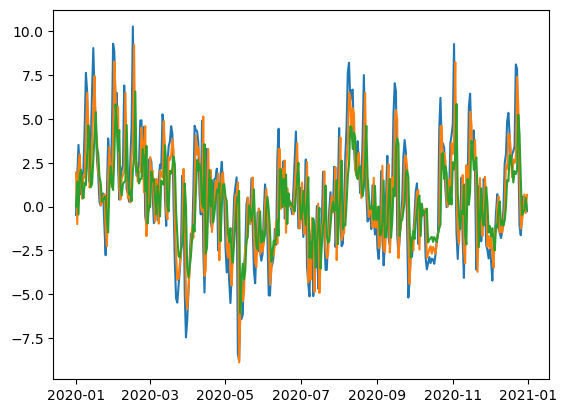

In [377]:
plt.plot(df_test["remainder"]/10.0)
plt.plot(df_forcast["forcast"]/10.0)
plt.plot(df_forcast["forcast_2D"]/10.0)

(18262.0, 18627.0)

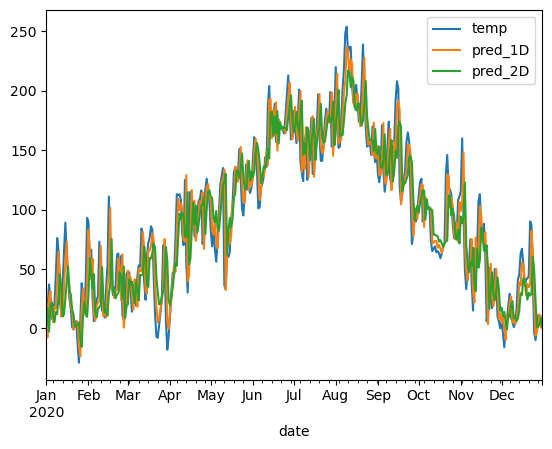

In [415]:
df_forcast_compare=df_test

df_forcast_compare["forcast_2D"]=df_forcast["forcast_2D"]

df_forcast_compare["pred_1D"]=df_forcast_compare["trend"]+df_forcast_compare["season"]+df_forcast["forcast"]
df_forcast_compare["pred_2D"]=df_forcast_compare["trend"]+df_forcast_compare["season"]+df_forcast["forcast_2D"]

df_forcast_compare[["temp", "pred_1D", "pred_2D"]].plot()
plt.xlim(pd.Timestamp("2020-01-01"),pd.Timestamp("2020-12-31"))


In [413]:
sum=0
for i,t in enumerate(df_forcast_compare["temp"]):
    diff=t-df_forcast_compare["pred_1D"][i]
    sum+=diff**2
rms=np.sqrt(sum/len(df_forcast_compare))

print("The root - mean - square value of the 1 Day prediction is", 
      round(rms,1), ", which correspond to ",round(rms/10,2),"°C")

The root - mean - square value of the 1D prediction is 21.3 , which correspond to  2.13 °C


In [414]:
sum=0
for i,t in enumerate(df_forcast_compare["temp"]):
    diff=t-df_forcast_compare["pred_2D"][i]
    sum+=diff**2
rms=np.sqrt(sum/len(df_forcast_compare))
print("The root - mean - square value of the 2 Day prediction is",
      round(rms,1), ", which correspond to ",round(rms/10,2),"°C")

The root - mean - square value of the 2 Day prediction is 29.5 , which correspond to  2.95 °C
